In [1]:
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.pylab as pl
import matplotlib as mpl
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import numpy as np
import warnings as wn
from xhistogram.xarray import histogram as xh
%reload_ext autoreload
%autoreload 2
import esm2m.myfunctions as func
from xhistogram.xarray import histogram as xh

In [2]:
wn.filterwarnings('ignore')
cod = pd.read_csv('species/atlantic_cod.csv', header=0)
bass = pd.read_csv('species/stripped_bass.csv', header=0)
flounder = pd.read_csv('species/summer_flounder.csv', header=0)
seabream = pd.read_csv('species/seabream.csv', header=0)
red_drum = pd.read_csv('species/red_drum.csv', header=0)
n_lampfish = pd.read_csv('species/northern_lampfish.csv', header=0)
blue_lampfish = pd.read_csv('species/blue_lampfish.csv', header=0)
cunner = pd.read_csv('species/cunner.csv', header=0)
eelpout = pd.read_csv('species/eelpout.csv', header=0)

In [3]:
rootdir = '/local/ss23/NEW_MI'
filename = 'MI_hitemp_sens_k01_ens*_1x1_1950_2100.nc'
path = rootdir+'/'+filename
z0_all = xr.open_mfdataset(path, engine='netcdf4', concat_dim='ensemble', combine='nested')
z0_avg = z0_all.mean(dim='ensemble')
z0Avg = xr.open_dataset('/home/aos/ystochel/esm2m/data/processed/MI_hitemp_sens_k01_ens130_1x1_1950_2100.nc')

In [4]:
rootdir = '/local/ss23/GFDL_LEs/'
experiment = 'OCN/METABOLIC_INDEX/RCP85'
filename = 'MI_hitemp_sens_k01_ens*_1x1_1950_2100.nc'
path = rootdir+experiment+'/'+filename
z0_all = xr.open_mfdataset(path, engine='netcdf4', concat_dim='ensemble', combine='nested')
z0_avg = z0_all.sel(ensemble=30)
z0_avg = z0_avg/2
z0_all = z0_all.sel(ensemble=slice(0,30))
z0_all = z0_all/2

In [5]:
rootdir = '/local/ss23/GFDL_LEs/'
subdir = 'AREA_FILES_ETC'
filename_area = 'WOA2001_grid.nc'
path_area = rootdir+subdir+'/'+filename_area
area = xr.open_dataset(path_area)['AREA'].rename({'latitude':'yt_ocean','longitude':'xt_ocean'})
area = area.assign_coords({'xt_ocean':z0_avg['xt_ocean'],'yt_ocean':z0_avg['yt_ocean']})
oceanmask = np.isfinite(z0_avg['MI'].isel(time=0).squeeze())
area_masked = area.where(oceanmask,np.nan)
ds_total = ~np.isnan(area.where(oceanmask))
total = ds_total.sum(dim='yt_ocean').sum(dim='xt_ocean')

In [11]:
def species(df_species):
    ds_cod = df_species.to_xarray()
    lon_bins = np.arange(-180,181)
    lat_bins = np.arange(-90,91)
    species_dist = xh(ds_cod['decimalLatitude'], ds_cod['decimalLongitude'],bins=[lat_bins, lon_bins])
    ds_hab = species_dist.where(species_dist<=1,1).rename({'decimalLongitude_bin':'xt_ocean','decimalLatitude_bin':'yt_ocean'})
    return ds_hab

In [12]:
def mi_dist(ds, mi, hab, area):
    hab = hab.to_dataset().rename({'histogram_decimalLatitude_decimalLongitude':'MI'})
    red = ~np.isnan(ds.where(ds['MI']>mi))
    hab = hab.reindex_like(red, method='nearest', tolerance=0.01)
    total_hab = (hab*area).sum(['xt_ocean','yt_ocean'])
    thresh_red = hab*red
    redWhere = ~np.isnan(thresh_red.where(thresh_red['MI']!=0))
    redYear = redWhere.groupby('time.year').mean().sel(year=slice(1990,2100))
    redNum = (redYear*area).sum(['xt_ocean','yt_ocean'])
    redPerc = (redNum['MI']/total_hab['MI'])*100
    redEns = redPerc.mean(dim='ensemble')
    return redEns

In [8]:
def plot_dist(red, orange, yel, gr, pur, species):
    fig, ax = plt.subplots(figsize=(10,8))
    wn.filterwarnings('ignore')
    fig.suptitle('RCP8.5 Ensemble Average, '+species+' Distribution, Z=0m (original data/2)')
    ax.plot(np.unique(red['year']),red,color='red',label='MI > 1')
    ax.plot(np.unique(orange['year']),orange,color='orange',label='MI > 2')
    ax.plot(np.unique(yel['year']),yel,color='yellow',label='MI > 3')
    ax.plot(np.unique(gr['year']),gr,color='green',label='MI > 4')
    ax.plot(np.unique(pur['year']),pur,color='purple',label='MI > 5')
    ax.legend()
    ax.set_xlabel('Year')
    ax.set_ylabel('Habitable Percent of Distribution')
    # orPerc['MI'].sel(year=slice(1990,2100)).plot()

# Atlantic Cod

#### E0 = 0.42, A0 = 15.6, MI-crit = 2.1-2.2

In [13]:
cod_hab = species(cod)
red_cod = mi_dist(z0_all, 1.0, cod_hab, area_masked)
or_cod = mi_dist(z0_all, 2.0, cod_hab, area_masked)
yel_cod = mi_dist(z0_all, 3.0, cod_hab, area_masked)
gr_cod = mi_dist(z0_all, 4.0, cod_hab, area_masked)
pur_cod = mi_dist(z0_all, 5.0, cod_hab, area_masked)

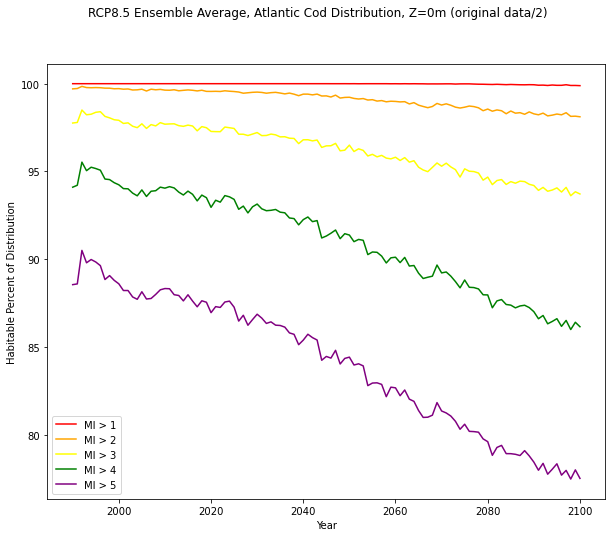

In [10]:
plot_dist(red_cod, or_cod, yel_cod, gr_cod, pur_cod, 'Atlantic Cod')

# Striped Bass

#### E0 = 0.33, A0 = 24, MI-crit = 4.8-5.0

In [15]:
bass_hab = species(bass)
red_bass = mi_dist(z0_all, 1.0, bass_hab, area_masked)
or_bass = mi_dist(z0_all, 2.0, bass_hab, area_masked)
yel_bass = mi_dist(z0_all, 3.0, bass_hab, area_masked)
gr_bass = mi_dist(z0_all, 4.0, bass_hab, area_masked)
pur_bass = mi_dist(z0_all, 5.0, bass_hab, area_masked)

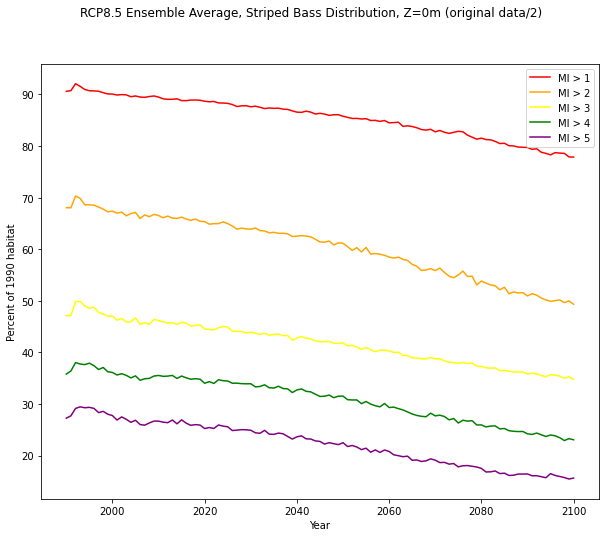

In [40]:
plot_dist(red_bass, or_bass, yel_bass, gr_bass, pur_bass, 'Striped Bass')

# Summer Flounder

#### E0 = 0.35, A0 = 25.1, MI-crit = 3.5-3.6

In [16]:
flounder_hab = species(flounder)
red_flounder = mi_dist(z0_all, 1.0, flounder_hab, area_masked)
or_flounder = mi_dist(z0_all, 2.0, flounder_hab, area_masked)
yel_flounder = mi_dist(z0_all, 3.0, flounder_hab, area_masked)
gr_flounder = mi_dist(z0_all, 4.0, flounder_hab, area_masked)
pur_flounder = mi_dist(z0_all, 5.0, flounder_hab, area_masked)

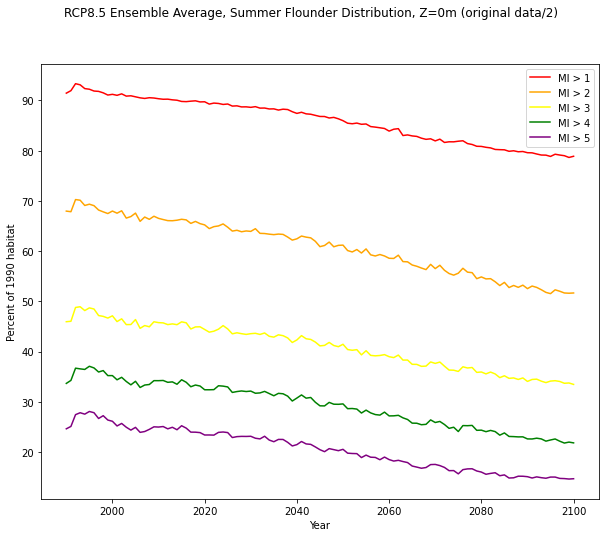

In [42]:
plot_dist(red_flounder, or_flounder, yel_flounder, gr_flounder, pur_flounder, 'Summer Flounder')

# Sharpsnout Seabream

#### E0 = 0.23, A0 = 53.9, MI-crit = 4.2

In [17]:
seabream_hab = species(seabream)
red_seabream = mi_dist(z0_all, 1.0, seabream_hab, area_masked)
or_seabream = mi_dist(z0_all, 2.0, seabream_hab, area_masked)
yel_seabream = mi_dist(z0_all, 3.0, seabream_hab, area_masked)
gr_seabream = mi_dist(z0_all, 4.0, seabream_hab, area_masked)
pur_seabream = mi_dist(z0_all, 5.0, seabream_hab, area_masked)

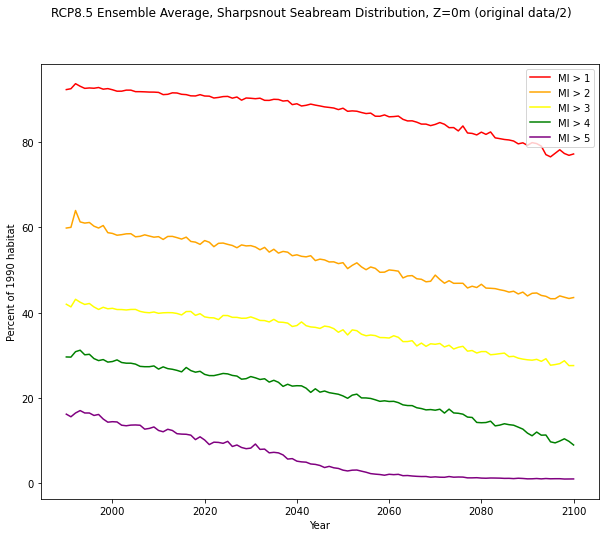

In [44]:
plot_dist(red_seabream, or_seabream, yel_seabream, gr_seabream, pur_seabream, 'Sharpsnout Seabream')

# Red Drum

#### E0 = 0.24, A0 = 32.3, MI-crit = 5.0-5.1

In [18]:
drum_hab = species(red_drum)
red_drum = mi_dist(z0_all, 1.0, drum_hab, area_masked)
or_drum = mi_dist(z0_all, 2.0, drum_hab, area_masked)
yel_drum = mi_dist(z0_all, 3.0, drum_hab, area_masked)
gr_drum = mi_dist(z0_all, 4.0, drum_hab, area_masked)
pur_drum = mi_dist(z0_all, 5.0, drum_hab, area_masked)

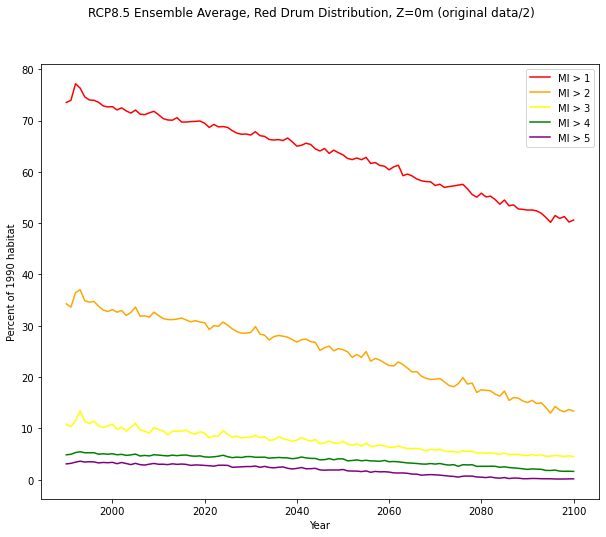

In [46]:
plot_dist(red_drum, or_drum, yel_drum, gr_drum, pur_drum, 'Red Drum')

# Northern Lampfish

#### E0 = 0.69, A0 = 23.4, MI-crit = 2.2-4.4

In [19]:
lamp_hab = species(n_lampfish)
red_lamp = mi_dist(z0_all, 1.0, lamp_hab, area_masked)
or_lamp = mi_dist(z0_all, 2.0, lamp_hab, area_masked)
yel_lamp = mi_dist(z0_all, 3.0, lamp_hab, area_masked)
gr_lamp = mi_dist(z0_all, 4.0, lamp_hab, area_masked)
pur_lamp = mi_dist(z0_all, 5.0, lamp_hab, area_masked)

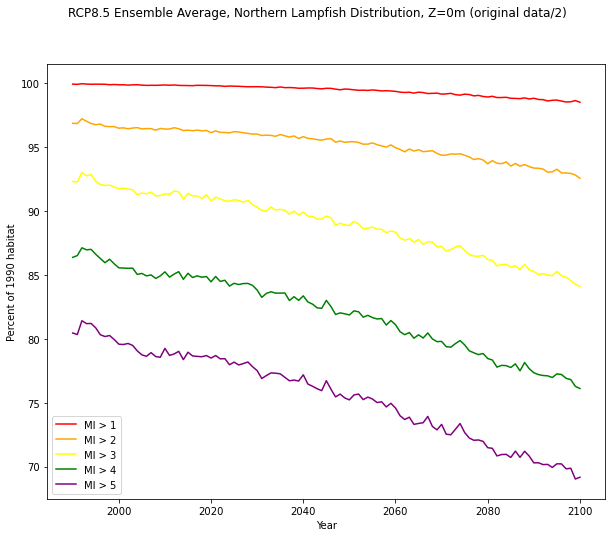

In [48]:
plot_dist(red_lamp, or_lamp, yel_lamp, gr_lamp, pur_lamp, 'Northern Lampfish')

# Blue Lampfish

#### E0 = 0.21, A0 = 20.6, MI-crit = 2.6-4.8

In [20]:
blue_hab = species(blue_lampfish)
red_blue = mi_dist(z0_all, 1.0, blue_hab, area_masked)
or_blue = mi_dist(z0_all, 2.0, blue_hab, area_masked)
yel_blue = mi_dist(z0_all, 3.0, blue_hab, area_masked)
gr_blue = mi_dist(z0_all, 4.0, blue_hab, area_masked)
pur_blue = mi_dist(z0_all, 5.0, blue_hab, area_masked)

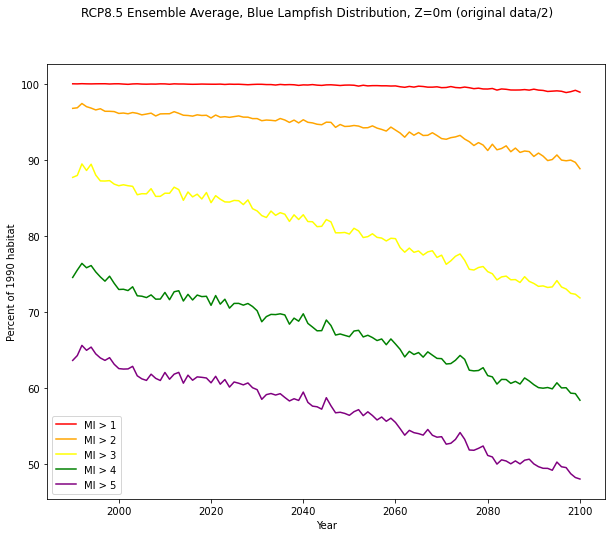

In [55]:
plot_dist(red_blue, or_blue, yel_blue, gr_blue, pur_blue, 'Blue Lampfish')

# Cunner

#### E0 = 0.22, A0 = 22.2, MI-crit = 3.8-4.0

In [21]:
cunner_hab = species(cunner)
red_cunner = mi_dist(z0_all, 1.0, cunner_hab, area_masked)
or_cunner = mi_dist(z0_all, 2.0, cunner_hab, area_masked)
yel_cunner = mi_dist(z0_all, 3.0, cunner_hab, area_masked)
gr_cunner = mi_dist(z0_all, 4.0, cunner_hab, area_masked)
pur_cunner = mi_dist(z0_all, 5.0, cunner_hab, area_masked)

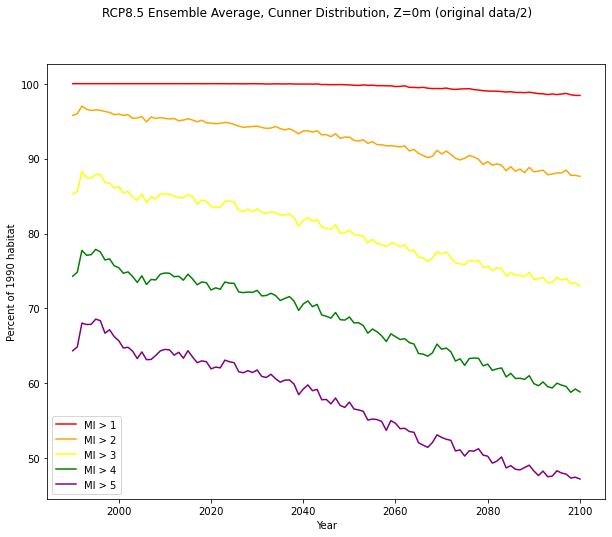

In [57]:
plot_dist(red_cunner, or_cunner, yel_cunner, gr_cunner, pur_cunner, 'Cunner')

# Viviparous Eelpout

#### E0 = 0.85, A0 = 18.2, MI-crit = 3.6-4.4

In [22]:
eel_hab = species(eelpout)
red_eel = mi_dist(z0_all, 1.0, eel_hab, area_masked)
or_eel = mi_dist(z0_all, 2.0, eel_hab, area_masked)
yel_eel = mi_dist(z0_all, 3.0, eel_hab, area_masked)
gr_eel = mi_dist(z0_all, 4.0, eel_hab, area_masked)
pur_eel = mi_dist(z0_all, 5.0, eel_hab, area_masked)

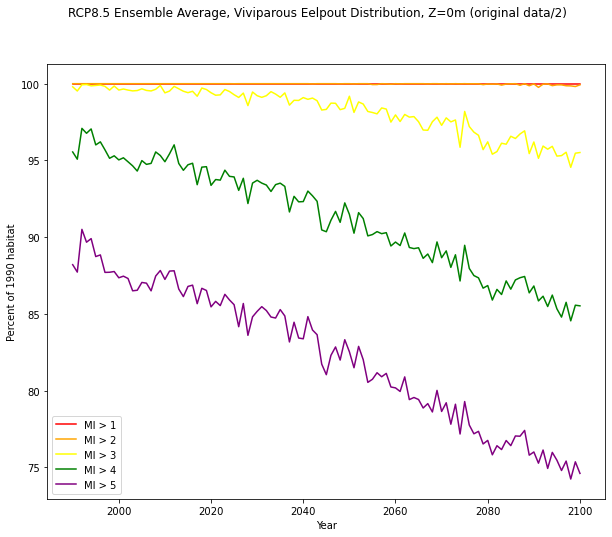

In [59]:
plot_dist(red_eel, or_eel, yel_eel, gr_eel, pur_eel, 'Viviparous Eelpout')

# Summary

Text(0, 0.5, 'Habitable Percent of Distribution')

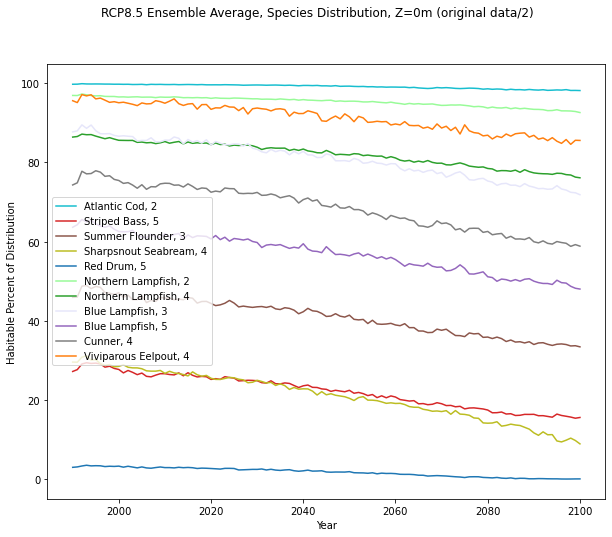

In [23]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('RCP8.5 Ensemble Average, Species Distribution, Z=0m (original data/2)')
ax.plot(np.unique(or_cod['year']),or_cod,color='tab:cyan',label='Atlantic Cod, 2')
ax.plot(np.unique(pur_bass['year']),pur_bass,color='tab:red',label='Striped Bass, 5')
ax.plot(np.unique(yel_flounder['year']),yel_flounder,color='tab:brown',label='Summer Flounder, 3')
ax.plot(np.unique(gr_seabream['year']),gr_seabream,color='tab:olive',label='Sharpsnout Seabream, 4')
ax.plot(np.unique(pur_drum['year']),pur_drum,color='tab:blue',label='Red Drum, 5')
ax.plot(np.unique(or_lamp['year']),or_lamp,color='palegreen',label='Northern Lampfish, 2')
ax.plot(np.unique(gr_lamp['year']),gr_lamp,color='tab:green',label='Northern Lampfish, 4')
ax.plot(np.unique(yel_blue['year']),yel_blue,color='lavender',label='Blue Lampfish, 3')
ax.plot(np.unique(pur_blue['year']),pur_blue,color='tab:purple',label='Blue Lampfish, 5')
ax.plot(np.unique(gr_cunner['year']),gr_cunner,color='tab:gray',label='Cunner, 4')
ax.plot(np.unique(gr_eel['year']),gr_eel,color='tab:orange',label='Viviparous Eelpout, 4')
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Habitable Percent of Distribution')

# Histogram

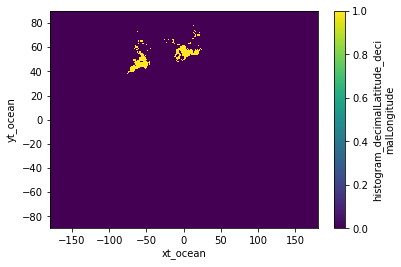

In [14]:
cod_hab.plot()